In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import skellam
import matplotlib.pyplot as plt
import math
import scipy.special

In [2]:
#Importing and creating our datframe
Data10=pd.read_csv("../Data/2009-2010.csv")
Data9=pd.read_csv("../Data/2008-2009.csv")
Data8=pd.read_csv("../Data/2007-2008.csv")
Data7=pd.read_csv("../Data/2006-2007.csv")
Data=pd.concat([Data7,Data8,Data9,Data10],sort=False,ignore_index=True)
Data=Data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
Data.columns=['Home','Away','HG','AG','Result']
Out=["Lecce","Messina","Ascoli","Reggina","Empoli","Torino"]
for out in Out:
    Data = Data.loc[Data.Home != out]
    Data = Data.loc[Data.Away != out]
Data=Data.reset_index()
Team=Data.Home.value_counts().index
Data['diff_score']=Data['HG']-Data['AG']


In [13]:
#Creating a dataframe with the updating coeficients 
coef=pd.DataFrame({'Team':Team})
coef['Att']=np.random.normal(0,0.01,len(coef))
coef['Dif']=np.random.normal(0,0.01,len(coef))
coef.iloc[0]['Att']=coef.iloc[0]['Att'] -sum(coef['Att'].values)
coef.iloc[0]['Dif']=coef.iloc[0]['Dif'] -sum(coef['Dif'].values)
#For identifiability need to set first team
coef=coef.set_index('Team').sort_index()

delta = np.random.normal(0,0.01)

coef

C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Att,Dif
Team,,
Atalanta,0.002620,0.020874
Bari,0.001124,0.011595
Bologna,-0.012157,0.008896
Cagliari,0.011434,0.003728
Catania,0.011199,-0.006700
Chievo,-0.002329,0.003862
Fiorentina,0.018405,0.005966
Genoa,0.004124,-0.002850
Inter,0.015136,-0.007886


In [4]:
#Calculate the means of our distribution
def score_coef(att,dif,delta,Data):
    mu1=np.array([])
    mu2=np.array([])
    for i in Data.index:
        m1=np.exp(delta+att.loc[Data.loc[i].Home]-dif.loc[Data.loc[i].Away])
        m2=np.exp(att.loc[Data.loc[i].Away]-dif.loc[Data.loc[i].Home])
        mu1=np.append(mu1,m1)
        mu2=np.append(mu2,m2)
    return mu1, mu2

In [5]:
def log_prior (coef_att,coef_dif,delta):
    e= norm.logpdf(delta, loc=0, scale=0.1)
    for i in range(len(coef_att)):
        e=+ norm.logpdf(coef_att[i], loc=0, scale=0.1)+ norm.logpdf(coef_dif[i], loc=0, scale=0.01)
    return e

In [6]:
def log_poisson(mu1,mu2,Data):
    D=0
    for i in range(len(Data)):
        D+=Data['HG'].iloc[i]*np.log(mu1.iloc[i])-mu1.iloc[i]-np.log(math.factorial(Data['HG'].iloc[i]))+Data['AG'].iloc[i]*np.log(mu2.iloc[i])-mu2.iloc[i]-np.log(math.factorial(Data['AG'].iloc[i]))
    return D

In [7]:
#Calculate unomralised log posterior
def log_tot (Data,X):
    coef_att=np.concatenate(([-sum(X[1:20])],X[1:20]))
    coef_def=np.concatenate(([-sum(X[20:39])],X[20:39]))
    H=X[0]
    N=log_prior(coef_att,coef_def,H)
    coef['i1']=coef_att
    coef['i2']=coef_def
    L1,L2=score_coef(coef['i1'],coef['i2'],H,Data)
    Data['j1']=L1
    Data['j2']=L2
    N+=log_poisson(Data['j1'],Data['j2'],Data)
    return N 

In [8]:
#Approximate the gradient of our log_posterior likelihood by finite differences 
def approx_gradient(Data,X,h=0.01):
    X_1=np.copy(X)
    X_2=np.copy(X)
    grad=np.ones(len(X_1))
    for i in range(0,len(X_1)):
        X_1[i]+=h
        X_2[i]-=h
        unnorm1=log_tot(Data,X_1)
        unnorm2=log_tot(Data,X_2)
        grad[i]=(unnorm1-unnorm2)/(2*h)
        X_2[i]+=h
        X_1[i]-=h
    return grad
        

In [37]:
#Backtracking Line search Gradient Descent
def Gradient_Descent(Data,X0,max_iter=500,rate=0.00005, alpha=0.2):
    coef=X0
    energy=[]
    j=0
    for i in range(1,max_iter+1):
        grad=approx_gradient(Data,coef)
        grad=np.multiply(-1,grad)
        coef_candidate=coef-rate*grad
        unorm=np.multiply(-1,log_tot(Data,coef))
        unorm_candidate=np.multiply(-1,log_tot(Data,coef_candidate))
        print(unorm_candidate)
        energy.append(unorm_candidate)
        while  unorm_candidate > unorm - rate*alpha*np.linalg.norm(grad)**2:
            print('w')
            rate *= alpha
            coef_candidate=coef-rate*grad
            j+= 1
            if j > 10000:
                print("more than 10000 iterations to adjust the step size")
                break
        coef = coef_candidate

    return coef,energy
    


In [38]:
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20]]))
theta0

array([-0.0036693 ,  0.00112428, -0.0121568 ,  0.01143404,  0.01119871,
       -0.00232872,  0.01840514,  0.00412353,  0.01513605,  0.00356619,
        0.01226467,  0.01019512,  0.00483737,  0.00449473, -0.01655441,
        0.00850212, -0.0100895 , -0.00885187,  0.00072413,  0.00355057,
        0.01159483,  0.00889558,  0.003728  , -0.0067002 ,  0.00386247,
        0.00596582, -0.00284973, -0.00788561,  0.00067135,  0.00042901,
       -0.00090989, -0.00459982,  0.00345801,  0.00243267,  0.00289366,
        0.00498535, -0.00778943,  0.0244961 ,  0.00900109])

In [39]:
New_coef,energy =Gradient_Descent(Data,theta0)

3392.8520918081485
3375.1771462340585
3359.5037856006093
3345.5874475991022
3333.239969500497
3322.2952786218048
3312.601622377974
3304.0198040946416
3296.4226442582362
3289.694585931392


In [19]:
#Add the return coefficients to the Data frame 
coef['Pred_Att']=np.concatenate(([-sum(New_coef[1:20])],New_coef[1:20]))
coef['Pred_Dif']=np.concatenate(([-sum(New_coef[20:])],New_coef[20:]))
coef['Home_Adv']=New_coef[0]

In [20]:
coef

,Att,Dif,i1,i2,Pred_Att,Pred_Dif,Home_Adv
Team,,,,,,,
Atalanta,0.002620,0.020874,-0.018599,-0.091201,-0.018599,-0.091201,0.388045
Bari,0.001124,0.011595,-0.035638,0.028221,-0.035638,0.028221,0.388045
Bologna,-0.012157,0.008896,-0.170598,-0.152875,-0.170598,-0.152875,0.388045
Cagliari,0.011434,0.003728,-0.021754,-0.090083,-0.021754,-0.090083,0.388045
Catania,0.011199,-0.006700,-0.186796,-0.020745,-0.186796,-0.020745,0.388045
Chievo,-0.002329,0.003862,-0.279400,0.052923,-0.279400,0.052923,0.388045
Fiorentina,0.018405,0.005966,0.036846,0.168543,0.036846,0.168543,0.388045
Genoa,0.004124,-0.002850,0.028580,-0.075730,0.028580,-0.075730,0.388045
Inter,0.015136,-0.007886,0.406192,0.310999,0.406192,0.310999,0.388045


In [101]:
coef.to_csv('Coef_Gradient_Descent.csv')

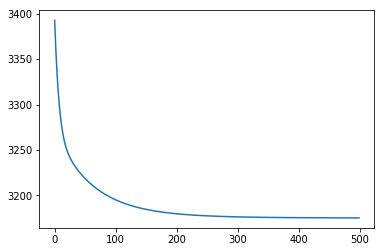

In [22]:
#Plot minimization of negative Loglikelihood
Neg_log_likeli=energy
plt.plot(Neg_log_likeli)
plt.savefig('grad_descent.png')
plt.show()